In [97]:
import numpy as np
import pandas as pd
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

import time
import re
import mlflow
from mlflow.models import infer_signature
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold

In [2]:
df = pd.read_csv("dataframe_final.csv")

On divise notre dataframe en train et test en fonction de la présence de l'information dans 'TARGET'.

In [25]:
train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]

print(f'train_df shape : {train_df.shape}')
print(f'test_df shape : {test_df.shape}')

train_df shape : (307507, 797)
test_df shape : (48744, 797)


In [98]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

# LOGISTIC REGRESSION

## Without SMOTE

In [99]:
mlflow.set_experiment("Project7_LRnoSMOTE")

2024/01/29 17:48:42 INFO mlflow.tracking.fluent: Experiment with name 'Project7_LRnoSMOTE' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/817303467258620465', creation_time=1706546922093, experiment_id='817303467258620465', last_update_time=1706546922093, lifecycle_stage='active', name='Project7_LRnoSMOTE', tags={}>

In [101]:
folds = KFold(n_splits=10, shuffle=True, random_state=1001)
feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
    train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
    valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]


Gestion des valeurs manquantes.

In [102]:
from sklearn.impute import SimpleImputer

train_x.replace([np.inf, -np.inf], np.nan, inplace=True)
valid_x.replace([np.inf, -np.inf], np.nan, inplace=True)
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
train_x = imp.fit_transform(train_x)
valid_x = imp.fit_transform(valid_x)

In [103]:
lr = LogisticRegression(random_state=0)
lr.fit(train_x, train_y)

roc_auc = roc_auc_score(valid_y, lr.predict_proba(valid_x)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(valid_y, lr.predict(valid_x)))

AUC : 0.5318
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     28297
         1.0       0.12      0.00      0.00      2453

    accuracy                           0.92     30750
   macro avg       0.52      0.50      0.48     30750
weighted avg       0.86      0.92      0.88     30750



<Axes: >

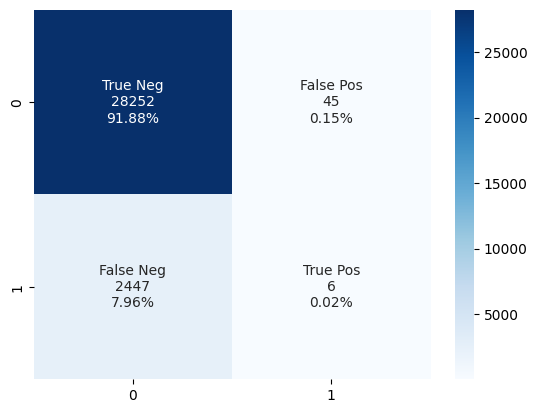

In [104]:
cf_matrix = confusion_matrix(valid_y, lr.predict(valid_x))
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

In [106]:
# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    #mlflow.log_params(params)

    # Log the loss metric
    mlflow.log_metric("roc_auc", roc_auc)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", "Basic LR model no SMOTE no param")

    # Infer the model signature
    signature = infer_signature(train_x, lr.predict(train_x))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=lr,
        artifact_path="dataframe_final.csv",
        signature=signature,
        input_example=train_x,
        registered_model_name="lr-first",
    )

MlflowException: API request to http://127.0.0.1:8080/api/2.0/mlflow-artifacts/artifacts/817303467258620465/d5a2cc6e97a74d87b94111f56a4e123b/artifacts/dataframe_final.csv/input_example.json failed with exception HTTPConnectionPool(host='127.0.0.1', port=8080): Max retries exceeded with url: /api/2.0/mlflow-artifacts/artifacts/817303467258620465/d5a2cc6e97a74d87b94111f56a4e123b/artifacts/dataframe_final.csv/input_example.json (Caused by ProtocolError('Connection aborted.', ConnectionResetError(10054, 'Une connexion existante a dû être fermée par l’hôte distant', None, 10054, None)))

## With SMOTE

In [95]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

steps = [('over', SMOTE(random_state=0)), ('model', LogisticRegression(random_state=0))]
pipeline = Pipeline(steps=steps)
pipeline.fit(train_x, train_y)

roc_auc = roc_auc_score(valid_y, pipeline.predict_proba(valid_x)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(valid_y, pipeline.predict(valid_x)))

AUC : 0.5444
              precision    recall  f1-score   support

         0.0       0.92      0.86      0.89     28297
         1.0       0.10      0.19      0.13      2453

    accuracy                           0.80     30750
   macro avg       0.51      0.52      0.51     30750
weighted avg       0.86      0.80      0.83     30750



<Axes: >

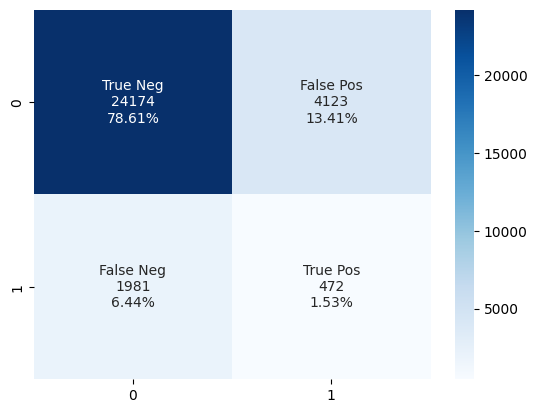

In [94]:
cf_matrix = confusion_matrix(valid_y, pipeline.predict(valid_x))
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')